# Chemical Word Characterization 

In this notebook, we will conduct several analyses to characterize chemical words. The analyses include 
- computing frequencies of these words in BDB dataset [1], and its subsets comprising only strong binders (i.e. having affinity > 7) and weak binders (i.e. having affinity < 7), 
- identifying chemical words exclusive to strong and weak binders sets, 
- finding valid chemical words inside the vocabulary, 

## Importing Libraries & Data 

In [1]:
!pip install seaborn
!pip install tokenizers
!pip install plotly

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import re
from pathlib import Path
from tokenizers import Tokenizer

sns.set('notebook')

In [3]:
chem_tokenizer = Tokenizer.from_file('../data/vocab.json')

References
    [1]  Philippe Schwaller, Teodoro Laino, Théophile Gaudin, Peter Bolgar, Christopher A. Hunter, Costas Bekas, and Alpha A. Lee
        ACS Central Science 2019 5 (9): Molecular Transformer: A Model for Uncertainty-Calibrated Chemical Reaction Prediction
        1572-1583 DOI: 10.1021/acscentsci.9b00576

In [4]:
SMI_REGEX_PATTERN = "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#||\+|\\\\\/|:||@|\?|>|\*|\$|\%[0–9]{2}|[0–9])"
regex = re.compile(SMI_REGEX_PATTERN)

In [5]:
df_words = pd.DataFrame(list(chem_tokenizer.get_vocab()))
df_words['length'] = df_words[0].apply(lambda s: len([token for token in regex.findall(s)]))

In [6]:
df_words.length.describe()

count    8000.000000
mean        9.940250
std         5.267817
min         2.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        98.000000
Name: length, dtype: float64

In [7]:
df_words.length.isna().sum()

0

In [8]:
sns.set('paper')

In [9]:
# fig,ax = plt.subplots(2,2, figsize=(15,8))
# ax=ax.flatten()
# sns.stripplot(x='bin', y='length', data=df_words, ax=ax[0])
# sns.violinplot(x='bin', y='length', data=df_words, ax=ax[1])
# sns.boxplot(x='bin', y='length', data=df_words, ax=ax[2])
# sns.barplot(x='bin', y='length', data=df_words, ax=ax[3])

In [10]:
df_words['bin'] = pd.cut(df_words['length'], bins=[1, 4, 6, 9, 12, 15, 100], labels=['1-4','4-6', '6-9', '9-12', '12-15', '15-100'])
df_words.groupby('bin')['length'].count().reset_index()

,bin,length
0,1-4,673
1,4-6,1440
2,6-9,2305
3,9-12,1588
4,12-15,1051
5,15-100,943


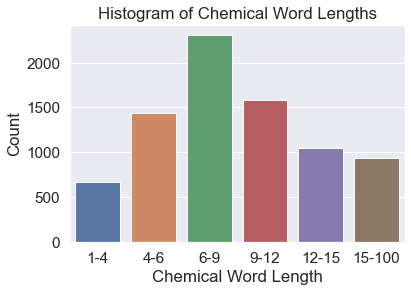

In [11]:
sns.set(font_scale=1.4)

ax = sns.barplot(x='bin', y='length', data=df_words.groupby('bin')['length'].count().reset_index())
ax.set(xlabel='Chemical Word Length', ylabel='Count', title='Histogram of Chemical Word Lengths')
plt.show()

In [12]:
import sys
sys.path.append('../')
from data import load_bdb, load_lit_pcba, load_protein_class


In [13]:
bdb_active = set(sum(load_bdb('active').values(), []))
bdb_inactive = set(sum(load_bdb('inactive').values(), []))
bdb = pd.DataFrame(bdb_active | bdb_inactive, columns=['smiles'])
bdb['words'] = bdb['smiles'].apply(lambda s: chem_tokenizer.encode(s).tokens)
bdb_appeared_words = bdb.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
bdb_appeared_words

..\data.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

..\data.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,words
0,S,369
1,([O-]),343
2,(=O)=O),308
3,C(O),177
4,=O,124
...,...,...
1596,c2c1C,1
1597,c23)c1,1
1598,NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(N)=O),1
1599,c2cc3ccccc3cc2,1


Number of unique smiles in BDB

In [14]:
bdb.shape

(924, 2)

Number of chemical words appeared in BDB

In [15]:
bdb_appeared_words.shape[0] / chem_tokenizer.get_vocab_size() * 100

20.0125

In [16]:
df_bdb_active = pd.DataFrame(bdb_active, columns=['smiles'])
df_bdb_active['words'] = df_bdb_active['smiles'].apply(lambda s: chem_tokenizer.encode(s).tokens)
bdb_active_appeared_words = df_bdb_active.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
bdb_active_appeared_words.shape[0] / chem_tokenizer.get_vocab_size() * 100

17.3875

In [17]:
df_bdb_inactive = pd.DataFrame(bdb_inactive, columns=['smiles'])
df_bdb_inactive['words'] = df_bdb_inactive['smiles'].apply(lambda s: chem_tokenizer.encode(s).tokens)
bdb_inactive_appeared_words = df_bdb_inactive.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
bdb_inactive_appeared_words.shape[0] / chem_tokenizer.get_vocab_size() * 100

17.5125

In [18]:
unique_active_words = set(bdb_active_appeared_words['index'].tolist()) - set(bdb_inactive_appeared_words['index'].tolist())
unique_inactive_words = set(bdb_inactive_appeared_words['index'].tolist()) - set(bdb_active_appeared_words['index'].tolist())
len(unique_active_words), len(unique_inactive_words)

(200, 210)

In [19]:
bdb_active_word_freq = df_bdb_active.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
bdb_active_word_freq

,index,words
0,S,253
1,([O-]),242
2,(=O)=O),226
3,C(O),101
4,\,92
...,...,...
1386,(C(=O)N,1
1387,c2nc3ccccc3s2),1
1388,cc(=O),1
1389,c3n2),1


In [20]:
bdb_active_word_freq['qbin'] = pd.qcut(bdb_active_word_freq['words'], 8, duplicates='drop')
bdb_active_word_freq

,index,words,qbin
0,S,253,"(10.0, 253.0]"
1,([O-]),242,"(10.0, 253.0]"
2,(=O)=O),226,"(10.0, 253.0]"
3,C(O),101,"(10.0, 253.0]"
4,\,92,"(10.0, 253.0]"
...,...,...,...
1386,(C(=O)N,1,"(0.999, 2.0]"
1387,c2nc3ccccc3s2),1,"(0.999, 2.0]"
1388,cc(=O),1,"(0.999, 2.0]"
1389,c3n2),1,"(0.999, 2.0]"


In [21]:
bdb_active_word_freq['bin'] = pd.cut(bdb_active_word_freq['words'], bins=[0, 1, 2, 3, 5, 10, 25, 253], labels=['1', '2', '3', '3-5', '5-10', '10-25', '25-253'])
df_freqs = bdb_active_word_freq.groupby('bin')['words'].count().reset_index()
df_freqs['percentage'] = df_freqs['words'] / df_freqs['words'].sum() * 100
df_freqs

,bin,words,percentage
0,1,563,40.474479
1,2,234,16.822430
2,3,150,10.783609
3,3-5,149,10.711718
4,5-10,128,9.202013
5,10-25,130,9.345794
6,25-253,37,2.659957


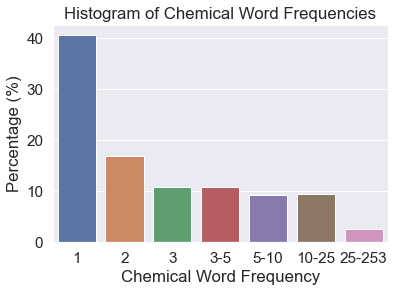

In [22]:
sns.set(font_scale=1.4)

ax = sns.barplot(x='bin', y='percentage', data=df_freqs)
ax.set(xlabel='Chemical Word Frequency', ylabel='Percentage (%)', title='Histogram of Chemical Word Frequencies')
plt.show()

In [23]:
bdb_word_freq = bdb.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
bdb_word_freq['bin'] = pd.cut(bdb_word_freq['words'], bins=[0, 1, 2, 3, 5, 10, 25, 253], labels=['1', '2', '3', '3-5', '5-10', '10-25', '25-253'])
df_freqs = bdb_word_freq.groupby('bin')['words'].count().reset_index()
df_freqs['percentage'] = df_freqs['words'] / df_freqs['words'].sum() * 100
df_freqs

,bin,words,percentage
0,1,601,37.609512
1,2,261,16.332916
2,3,164,10.262829
3,3-5,169,10.575720
4,5-10,181,11.326658
5,10-25,155,9.699625
6,25-253,67,4.192741


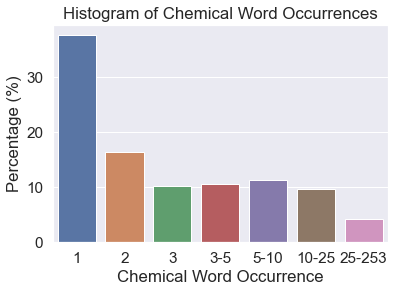

In [24]:
sns.set(font_scale=1.4)

ax = sns.barplot(x='bin', y='percentage', data=df_freqs)
ax.set(xlabel='Chemical Word Occurrence', ylabel='Percentage (%)', title='Histogram of Chemical Word Occurrences')
plt.show()

### Unique and Common words as table

In [25]:
# from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
# from matplotlib import pyplot as plt

# venn2(subsets = (len(unique_active_words), len(unique_inactive_words), len(bdb_appeared_words)), set_labels = ('Strong Binders', 'Weak Binders'))


In [26]:
lit_pcba_active = set(sum(load_lit_pcba('active').values(), []))
lit_pcba_inactive = set(sum(load_lit_pcba('inactive').values(), []))
print(len(lit_pcba_active), len(lit_pcba_inactive))
lit_pcba = pd.DataFrame(lit_pcba_active | lit_pcba_inactive, columns=['smiles'])
lit_pcba['words'] = lit_pcba['smiles'].apply(lambda s: chem_tokenizer.encode(s).tokens)
lit_pcba_appeared_words = lit_pcba.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
lit_pcba_appeared_words

7761 382674


,index,words
0,+],67813
1,H,67805
2,[N,66021
3,\,53650
4,C,44580
...,...,...
5664,O[C@H]1[C@H](O)[C@H](O),1
5665,[C@@H](C)[C@@H]1O,1
5666,CC(C)C[C@H](NC(=O)[C@@H](,1
5667,C2C1,1


Number of interactions in LitPCBA

In [27]:
lit_pcba.shape

(382743, 2)

Number of chemical words appeared in LitPCBA

In [28]:
lit_pcba_appeared_words.shape[0] / chem_tokenizer.get_vocab_size() * 100

70.8625

In [29]:
df_lit_pcba_active = pd.DataFrame(lit_pcba_active, columns=['smiles'])
df_lit_pcba_active['words'] = df_lit_pcba_active['smiles'].apply(lambda s: chem_tokenizer.encode(s).tokens)
lit_pcba_active_appeared_words = df_lit_pcba_active.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
lit_pcba_active_appeared_words.shape[0] / chem_tokenizer.get_vocab_size() * 100

45.75

In [30]:
df_lit_pcba_inactive = pd.DataFrame(lit_pcba_inactive, columns=['smiles'])
df_lit_pcba_inactive['words'] = df_lit_pcba_inactive['smiles'].apply(lambda s: chem_tokenizer.encode(s).tokens)
lit_pcba_inactive_appeared_words = df_lit_pcba_inactive.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
lit_pcba_inactive_appeared_words.shape[0] / chem_tokenizer.get_vocab_size() * 100

70.8625

In [31]:
unique_active_words = set(lit_pcba_active_appeared_words['index'].tolist()) - set(lit_pcba_inactive_appeared_words['index'].tolist())
unique_inactive_words = set(lit_pcba_inactive_appeared_words['index'].tolist()) - set(lit_pcba_active_appeared_words['index'].tolist())
len(unique_active_words), len(unique_inactive_words)

(0, 2009)

In [33]:
lit_pcba_active_word_freq = df_lit_pcba_active.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
lit_pcba_active_word_freq['bin'] = pd.cut(lit_pcba_active_word_freq['words'], bins=[0, 1, 2, 3, 5, 10, 25, 2500], labels=['1', '2', '3', '3-5', '5-10', '10-25', '25-2500'])
df_freqs = lit_pcba_active_word_freq.groupby('bin')['words'].count().reset_index()
df_freqs['percentage'] = df_freqs['words'] / df_freqs['words'].sum() * 100
df_freqs

,bin,words,percentage
0,1,828,22.622951
1,2,521,14.234973
2,3,339,9.262295
3,3-5,491,13.415301
4,5-10,523,14.289617
5,10-25,460,12.568306
6,25-2500,498,13.606557


In [34]:
pd.qcut(lit_pcba_active_word_freq['words'], 10, duplicates='drop').value_counts()

(0.999, 2.0]      1349
(37.0, 1838.0]     359
(15.0, 37.0]       352
(2.0, 3.0]         339
(4.0, 6.0]         338
(6.0, 9.0]         320
(9.0, 15.0]        316
(3.0, 4.0]         287
Name: words, dtype: int64

In [35]:
pd.qcut(lit_pcba_active_word_freq['words'], 10, duplicates='drop').value_counts()

(0.999, 2.0]      1349
(37.0, 1838.0]     359
(15.0, 37.0]       352
(2.0, 3.0]         339
(4.0, 6.0]         338
(6.0, 9.0]         320
(9.0, 15.0]        316
(3.0, 4.0]         287
Name: words, dtype: int64

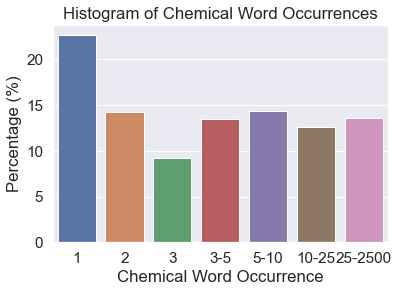

In [36]:
sns.set(font_scale=1.4)

ax = sns.barplot(x='bin', y='percentage', data=df_freqs)
ax.set(xlabel='Chemical Word Occurrence', ylabel='Percentage (%)', title='Histogram of Chemical Word Occurrences')
plt.show()

In [42]:
lit_pcba_word_freq = lit_pcba.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
lit_pcba_word_freq['bin'] = pd.cut(lit_pcba_word_freq['words'], bins=[0, 1, 2, 3, 5, 10, 25, 2500], labels=['1', '2', '3', '3-5', '5-10', '10-25', '25-2500'])
df_freqs = lit_pcba_word_freq.groupby('bin')['words'].count().reset_index()
df_freqs['percentage'] = df_freqs['words'] / df_freqs['words'].sum() * 100
df_freqs

,bin,words,percentage
0,1,200,3.698225
1,2,132,2.440828
2,3,99,1.830621
3,3-5,172,3.180473
4,5-10,351,6.490385
5,10-25,639,11.815828
6,25-2500,3815,70.543639


In [43]:
pd.qcut(lit_pcba_word_freq['words'], 10).value_counts()

(0.999, 5.0]        603
(14.0, 29.0]        588
(137.0, 224.0]      568
(979.4, 67813.0]    567
(397.4, 979.4]      567
(51.0, 87.0]        567
(224.0, 397.4]      563
(87.0, 137.0]       557
(29.0, 51.0]        556
(5.0, 14.0]         533
Name: words, dtype: int64

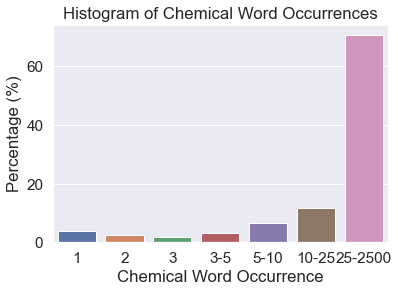

In [44]:
sns.set(font_scale=1.4)

ax = sns.barplot(x='bin', y='percentage', data=df_freqs)
ax.set(xlabel='Chemical Word Occurrence', ylabel='Percentage (%)', title='Histogram of Chemical Word Occurrences')
plt.show()

In [45]:
classes = ['epigenetic-regulators', 'hydrolases', 'ion-channels', 'membrane-receptors', 'other-enzymes', 
           'oxidoreductases', 'proteases', 'transcription-factors', 'transferases', 'transporters']

In [46]:
word_appearence = {}
for cl in classes: 
    p_class_active = set(sum(load_protein_class(cl, 'active').values(), []))
    p_class_inactive = set(sum(load_protein_class(cl, 'inactive').values(), []))
    p_class = pd.DataFrame(p_class_active | p_class_inactive, columns=['smiles'])
    p_class['words'] = p_class['smiles'].apply(lambda s: chem_tokenizer.encode(s).tokens)
    word_appearence[cl] = p_class.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index().shape[0]

..\data.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

..\data.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

..\data.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

..\data.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

..\data.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

..\data.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

..\data.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

..\data.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [47]:
{p_class: count / chem_tokenizer.get_vocab_size() * 100 for p_class, count in word_appearence.items()}

{'epigenetic-regulators': 62.74999999999999,
 'hydrolases': 92.25,
 'ion-channels': 80.10000000000001,
 'membrane-receptors': 93.4125,
 'other-enzymes': 77.14999999999999,
 'oxidoreductases': 86.4375,
 'proteases': 88.53750000000001,
 'transcription-factors': 75.5,
 'transferases': 92.7625,
 'transporters': 68.475}

In [48]:
from pathlib import Path 
bdb = pd.read_csv('../data/bdb/interactions.csv')

In [49]:
# df = pd.read_csv('../data/bdb/pfams.csv')
# family_to_prot = df.groupby('pfam_id')['prot_id'].apply(list).to_dict()
# family_to_count = {family: str(len(prot)) for family, prot in family_to_prot.items()}
# family_to_name = df.groupby('pfam_id')['pfam_name'].first().to_dict()
# prot_to_family = df.groupby('prot_id')['pfam_id'].first().to_dict()

## BDB dataset includes affinity measurements for 490 proteins and 924 ligands.

In [50]:
bdb['prot_id'].nunique(), bdb['smiles'].nunique()

(490, 924)

In [51]:
bdb['words'] = bdb['smiles'].apply(lambda s: chem_tokenizer.encode(s).tokens)

## Chemical Word Statistics

### Only 20% of 8K chemical words appear in BDB ligands.

In [52]:
bdb.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()

,index,words
0,S,369
1,([O-]),343
2,(=O)=O),308
3,C(O),177
4,=O,124
...,...,...
1596,CCN(CCO),1
1597,c2cccc(O),1
1598,c2nnc(C,1
1599,=,1


### 80% of the chemical words in BDB ligands are shared between strong and weak binders, but 200 and 210 unique words are exclusive to each respective set.

In [53]:
bdb_active = bdb.query('affinity_score > 7')
bdb_inactive = bdb.query('affinity_score < 7')
bdb_active_word_freq = bdb_active.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
bdb_inactive_word_freq = bdb_inactive.drop_duplicates('smiles').explode('words')['words'].value_counts().reset_index()
bdb_active_word_freq.shape[0], bdb_inactive_word_freq.shape[0]

(1391, 1401)

(<a list of 30 Patch objects>, <a list of 30 Patch objects>)

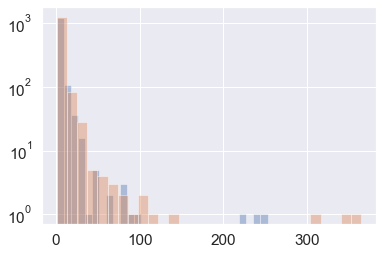

In [54]:
_, _, ax1 = plt.hist(bdb_active_word_freq['words'], log=True, bins=30, alpha=0.4)
_, _, ax2 = plt.hist(bdb_inactive_word_freq['words'], log=True, bins=30,  alpha=0.4)
ax1, ax2

In [55]:
active_word_list = bdb_active_word_freq['index'].tolist() 
inactive_word_list = bdb_inactive_word_freq['index'].tolist() 
unique_active_words = set(active_word_list) - set(inactive_word_list)
unique_inactive_words = set(inactive_word_list) - set(active_word_list)
len(unique_active_words), len(unique_inactive_words)

(200, 210)

In [56]:
bdb_active_word_freq[bdb_active_word_freq['index'].isin(unique_active_words)]

,index,words
159,CN4,11
235,O[C@@H](,7
257,CC4)cc3),7
280,CC(C)OC(=O),6
293,c2cc3ccc(,6
...,...,...
1369,c24),1
1372,CC2=O),1
1376,C[C@]1,1
1382,C(=O)O[C@@H]1,1


In [57]:
bdb_inactive_word_freq[bdb_inactive_word_freq['index'].isin(unique_inactive_words)]

,index,words
61,C(F)(F)C(F)(F)C(F)(F)C(F)(F),21
70,C(F)(F)C(F)(F),20
75,O[C@H](CO)[C@@H](O,20
76,CO[C@H]1,20
105,[C@H]1NC(C)=O,15
...,...,...
1368,)N(,1
1374,CC2)n1,1
1376,Cl)c1,1
1390,c1ccccc1)c1ccccc1),1


### Ratio of *valid* words are the same for strong binding and week binding ligands: ~0.2

In [58]:
from rdkit import Chem 
bdb_active_word_freq['valid_word'] = bdb_active_word_freq['index'].apply(lambda w: Chem.MolFromSmiles(w) is not None)
bdb_inactive_word_freq['valid_word'] = bdb_inactive_word_freq['index'].apply(lambda w: Chem.MolFromSmiles(w) is not None)

In [59]:
bdb_active_word_freq['valid_word'].value_counts()

False    1112
True      279
Name: valid_word, dtype: int64

In [60]:
bdb_inactive_word_freq['valid_word'].value_counts()

False    1121
True      280
Name: valid_word, dtype: int64

### ~90% of chemical words occur less than 12 times

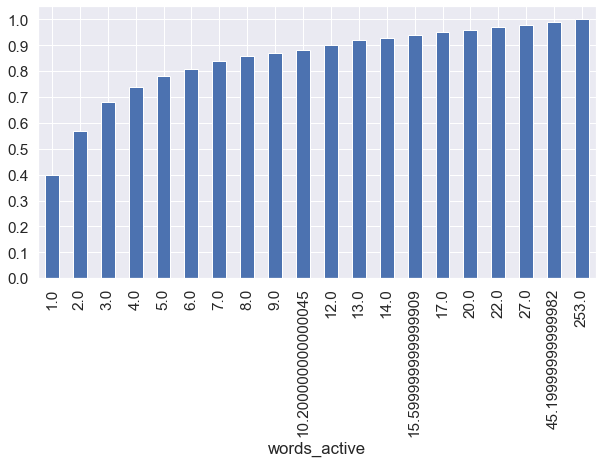

In [61]:
plt.figure(figsize=(10, 5))
bdb_words_with_freqs = pd.merge(bdb_active_word_freq, bdb_inactive_word_freq, on='index', suffixes=('_active', '_inactive'), how='outer')
bdb_words_with_freqs['words_active'].quantile([i/100 for i in range(101)]).reset_index().groupby('words_active')['index'].max().plot.bar(x='words_active', y='index')
plt.yticks([i/100 for i in range(0, 101, 10)])
plt.show()

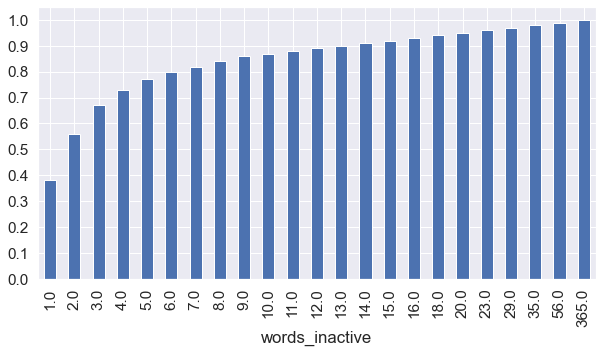

In [62]:
plt.figure(figsize=(10, 5))
bdb_words_with_freqs['words_inactive'].quantile([i/100 for i in range(101)]).reset_index().groupby('words_inactive')['index'].max().plot.bar(x='words_inactive', y='index')
plt.yticks([i/100 for i in range(0, 101, 10)])
plt.show()

### Chemical word frequency distributions are similar for strong binders and weak binders

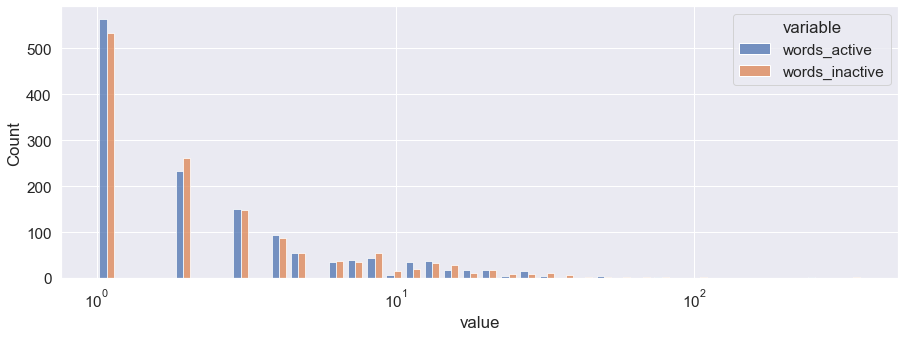

In [63]:
plt.figure(figsize=(15, 5))
sns.histplot(bdb_words_with_freqs[['words_active', 'words_inactive']].melt(), x='value', hue='variable',
             multiple='dodge', shrink=.75, bins=40, log_scale=True)

## PFAM family analyses

In [64]:
bdb_relevant = bdb[['ligand_id', 'prot_id', 'affinity_score', 'words']]
bdb_relevant['pfam_id'] = bdb_relevant['prot_id'].apply(lambda p: prot_to_family[p])
bdb_words = bdb_relevant.explode('words')
# bdb_words.to_csv('../data/bdb/word.csv', index=False)

NameError: name 'prot_to_family' is not defined

In [ ]:
bdb_relevant['pfam_id'].nunique()

### Interaction counts vary a lot across families.

In [ ]:
bdb_relevant['pfam_id'].value_counts()

### Similarly, protein counts per family vary a lot.

In [ ]:
bdb_protein_per_family = bdb_relevant.drop_duplicates(['pfam_id', 'prot_id']).groupby('pfam_id')['prot_id'].count().reset_index().sort_values(by='prot_id', ascending=False)
fig = px.bar(bdb_protein_per_family, x='pfam_id', y='prot_id', title='Number of proteins per family')
fig.show()

In [ ]:
bdb_strong_binder_per_family = bdb_relevant.query('affinity_score > 7').drop_duplicates(['pfam_id', 'ligand_id']).groupby('pfam_id')['ligand_id'].count().reset_index().sort_values(by='ligand_id', ascending=False)
bdb_weak_binder_per_family = bdb_relevant.query('affinity_score < 7').drop_duplicates(['pfam_id', 'ligand_id']).groupby('pfam_id')['ligand_id'].count().reset_index().sort_values(by='ligand_id', ascending=False)
fig = px.bar(bdb_strong_binder_per_family, x='pfam_id', y='ligand_id', title='Number of strong binders per family')
fig.show()

### 80% of families contain four or fewer proteins, with the largest family having a total of 169 proteins.

In [ ]:
bdb_protein_per_family.describe()

In [ ]:
plt.figure(figsize=(10, 5))
bdb_protein_per_family['prot_id'].quantile([i/25 for i in range(26)]).reset_index().groupby('prot_id')['index'].max().plot.bar(x='prot_id', y='index')
plt.yticks([i/100 for i in range(0, 101, 10)])
plt.show()

## Family-based Highlighted Words

### tf-idf score distribution

In [ ]:
import sys
sys.path.append('../')

In [ ]:
from highlighter import identify_highlights
from data import load_bdb

tf_idf_active, highlighted_words = identify_highlights(load_bdb(binders='active'))
tf_idf_active.reset_index(inplace=True)
tf_idf_active.rename(columns={"index": "pfam_id"}, inplace=True)
tf_idf_active = tf_idf_active.set_index("pfam_id").T

In [ ]:
highlighted_words['word'] = highlighted_words[highlighted_words.columns[:]].apply(
    lambda x: [i for i in ','.join(x.dropna().astype(str)).split(',') if len(i) > 0],
    axis=1
)
highlighted_words

In [ ]:
highlighted_words_freq = highlighted_words.explode('word')['word'].reset_index().groupby('word').count()
highlighted_words_freq

In [ ]:
pd.qcut(highlighted_words_freq['index'], 10, duplicates='drop').value_counts()

In [ ]:
highlighted_words_freq['bin'] = pd.cut(highlighted_words_freq['index'], bins=[0, 1, 2, 3, 5, 10, 20], labels=['1', '2', '3', '4-5', '5-10', '10-20'])
df_freqs = highlighted_words_freq.groupby('bin')['index'].count().reset_index()
df_freqs['percentage'] = df_freqs['index'] / df_freqs['index'].sum() * 100
df_freqs

In [ ]:
sns.set(style='ticks', palette='Set2')
sns.despine()


In [ ]:
!pip install SciencePlots
import scienceplots

plt.style.use('science')
g = sns.histplot(highlighted_words_freq['index'], binwidth=1, stat='percent', discrete=True)
g

In [ ]:
g = sns.histplot(highlighted_words_freq['index'], binwidth=1, stat='percent', discrete=True)
g

In [ ]:
sns.set(font_scale=1.4)

ax = sns.barplot(x='bin', y='percentage', data=df_freqs)
ax.set(xlabel='Chemical Word Occurrence', ylabel='Percentage (%)', title='Histogram of Highlighted Chemical Word Occurrences')
plt.show()

In [ ]:
tf_idf_active_flat = tf_idf_active.to_numpy().flatten()
_, _, ax = plt.hist(tf_idf_active_flat, log=True, bins=50)
plt.xlabel("tf-idf score")
plt.ylabel("chemical word count")
plt.title('tf-idf score distribution')
ax

### nonzero tf-idf score distribution

In [ ]:
_, _, ax = plt.hist(tf_idf_active_flat[tf_idf_active_flat > 0], log=True, bins=50)
plt.xlabel("tf-idf score")
plt.ylabel("chemical word count")
plt.title('(nonzero) tf-idf score distribution ')
ax

In [ ]:
from collections import Counter
# highlighted_words.fillna('', inplace=True)

highlighted_words_flatten = [w for w in highlighted_words.values.flatten().tolist() if w != ''] 
highlight_counts = Counter(highlighted_words_flatten)
word_family_freq = pd.DataFrame(highlight_counts.most_common(), columns=['word', 'family count'])
word_family_freq

### Cumulative distribution of highlighted words' occurrences in families
~60% of the highlighted words occur in only one family. 

~80% of the highlighted words occur at most two families. 

In [ ]:
word_family_freq['family count'].hist(cumulative=True, density=True, bins=list(range(1, word_family_freq['family count'].max()+1)))
plt.xticks(list(range(1, word_family_freq['family count'].max()+1)))
plt.xlabel('Chemical word occurrence')
plt.ylabel('Percentage (%)')
plt.title('Cumulative distribution of highlighted words\' occurrences in families')
plt.show()

In [ ]:
fig = px.bar(word_family_freq, x='word', y='family count', title='Chemical Word Occurrences in PFAM Families')
fig.show()

In [ ]:
from highlighter import identify_highlights
from data import load_lit_pcba

tf_idf_active, highlighted_words = identify_highlights(load_lit_pcba(binders='active'))

highlighted_words['word'] = highlighted_words[highlighted_words.columns[:]].apply(
    lambda x: [i for i in ','.join(x.dropna().astype(str)).split(',') if len(i) > 0],
    axis=1
)
highlighted_words

In [ ]:
highlighted_words_freq = highlighted_words.explode('word')['word'].reset_index().groupby('word').count()
highlighted_words_freq

In [ ]:
pd.qcut(highlighted_words_freq['index'], 10, duplicates='drop').value_counts()

### 51(21?) out of 79 families have significantly different tf-idf scores for chemical words in strong and weak binders.

In [ ]:
tf_idf_inactive, _ = identify_highlights(load_bdb(binders='inactive'))
tf_idf_inactive.reset_index(inplace=True)
tf_idf_inactive.rename(columns={"index": "pfam_id"}, inplace=True)
tf_idf_inactive = tf_idf_inactive.set_index("pfam_id").T

In [ ]:
union_index = tf_idf_active.index.union(tf_idf_inactive.index)

#### When zero terms are included: 103/168.  When zeros are excluded, 51/168

In [ ]:
from scipy.stats import ranksums
family_significance = []
for col in set(tf_idf_active.columns) & set(tf_idf_inactive.columns):  
    family_df = pd.merge(tf_idf_active[col].reset_index(), tf_idf_inactive[col].reset_index(), on='index', how='outer')
    family_df = family_df.fillna(0)
    family_df.columns = ['word', 'active', 'inactive']
    #ToDo: dropping words occurred none of them increases significant families by 15 (20-> 35)
    # family_df = family_df[(family_df['active'] != 0) | (family_df['inactive'] != 0)]
    _, upnorm = ranksums(family_df['active'].tolist(), family_df['inactive'].tolist())
    family_significance.append({'family': col, 'p-value': upnorm, 'significant': upnorm <= 0.05})
test_results = pd.DataFrame(family_significance)
test_results['significant'].value_counts()

In [ ]:
test_results

In [ ]:
pfam_family_names = df.groupby('pfam_id')['pfam_name'].first().to_dict()
test_results['family_name'] = test_results['family'].map(pfam_family_names)
test_results['family_count'] = test_results['family'].map(family_to_count)
test_results['family_active_int_count'] = test_results['family'].map(bdb_strong_binder_per_family.set_index('pfam_id')['ligand_id'].to_dict())
test_results['family_inactive_int_count'] = test_results['family'].map(bdb_weak_binder_per_family.set_index('pfam_id')['ligand_id'].to_dict())

In [ ]:
test_results.sort_values(by='p-value').to_csv('../results/bdb/significance.csv')

In [ ]:
test_results[["family_count", "family_active_int_count", "family_inactive_int_count"]] = test_results[["family_count", "family_active_int_count", "family_inactive_int_count"]].apply(pd.to_numeric)

In [ ]:
sns.displot(test_results, x="family_count", hue="significant", kind="kde", fill=True)

In [ ]:
sns.displot(test_results, x="family_active_int_count", hue="significant", kind="kde", fill=True)

In [ ]:
sns.displot(test_results, x="family_inactive_int_count", hue="significant", kind="kde", fill=True)

In [ ]:
# PF12605: Casein Kinase 1 gamma
# PF00850: Histone deacetylase 
# PF00194: Carbonic anhydrase
selected_family = 'PF00850'
#selected_family = tfidf_strong.columns[2]

In [ ]:
family_df = pd.merge(tf_idf_active[selected_family].reset_index(), tf_idf_inactive[selected_family].reset_index(), on='index', how='outer')
family_df = family_df.fillna(0)
family_df.columns = ['word', 'active', 'inactive']
family_df = family_df[(family_df['active'] != 0) | (family_df['inactive'] != 0)]
print(ranksums(family_df['active'].tolist(), family_df['inactive'].tolist()))
#family_df.sort_values(by='active')

In [ ]:
tf_idf_active_chosen =  tf_idf_active[selected_family]
tf_idf_active_chosen_nonzero = tf_idf_active_chosen[tf_idf_active_chosen > 0]
tf_idf_inactive_chosen =  tf_idf_inactive[selected_family]
tf_idf_inactive_chosen_nonzero = tf_idf_inactive_chosen[tf_idf_inactive_chosen > 0]
tf_idf_chosen_nonzero = pd.concat([tf_idf_active_chosen_nonzero.reset_index().assign(ligand='active'), tf_idf_inactive_chosen_nonzero.reset_index().assign(ligand='inactive')])
fig = px.bar(tf_idf_chosen_nonzero.sort_values(selected_family, ascending=False), x='index', y=selected_family, color='ligand')
fig.show()

## Overall frequency of words highlighted for families in the manuscript

In [ ]:
# PF12605: Casein Kinase 1 gamma
# PF00850: Histone deacetylase 
# PF00194: Carbonic anhydrase
paper_family_list = ['PF12605', 'PF00850', 'PF00194']
significant_families = test_results[test_results['significant']]
significant_families[significant_families.family.isin(paper_family_list)]

In [ ]:
bdb_words_with_freqs[bdb_words_with_freqs['index'].isin(CA_paper)]

In [ ]:
bdb_words_with_freqs[bdb_words_with_freqs['index'].isin(HDAC_paper)]

In [ ]:
bdb_words_with_freqs[bdb_words_with_freqs['index'].isin(CK1_paper)]

## Mean affinity scores per chemical word

In [ ]:
affinity_per_words = bdb_words.groupby('words').agg(mean_affinity_score=('affinity_score', 'mean')).sort_values('mean_affinity_score', ascending=False)
affinity_per_words

In [ ]:
fig = px.bar(affinity_per_words.reset_index(), x='words', y='mean_affinity_score')
fig.show()

In [ ]:
bdb_words[bdb_words['words'] == 'c4ccc(Cl)cc4)']

In [ ]:
bdb_words[bdb_words['words'] == 'c[nH]c12']

## Protein Class - Significance Analyses

In [ ]:
import pandas as pd
import sys
sys.path.append('../')

from highlighter import identify_highlights
from data import load_protein_class

classes = ['epigenetic-regulators','hydrolases', 'ion-channels', 'membrane-receptors', 'other-enzymes', 
           'oxidoreductases', 'proteases', 'transcription-factors', 'transferases', 'transporters']
family = classes[9]
tf_idf_active, _ = identify_highlights(load_protein_class(family=family, binders='active'))
tf_idf_active.reset_index(inplace=True)
tf_idf_active.rename(columns={"index": "target_id"}, inplace=True)
tf_idf_active = tf_idf_active.set_index("target_id").T

tf_idf_inactive, _ = identify_highlights(load_protein_class(family=family, binders='inactive'))
tf_idf_inactive.reset_index(inplace=True)
tf_idf_inactive.rename(columns={"index": "target_id"}, inplace=True)
tf_idf_inactive = tf_idf_inactive.set_index("target_id").T

In [ ]:
from scipy.stats import ranksums
family_significance = []
for col in set(tf_idf_active.columns) & set(tf_idf_inactive.columns):  
    family_df = pd.merge(tf_idf_active[col].reset_index(), tf_idf_inactive[col].reset_index(), on='index', how='outer')
    family_df = family_df.fillna(0)
    family_df.columns = ['word', 'active', 'inactive']
    #ToDo: dropping words occurred none of them increases significant families by 15 (20-> 35)
    family_df = family_df[(family_df['active'] != 0) | (family_df['inactive'] != 0)]
    _, upnorm = ranksums(family_df['active'].tolist(), family_df['inactive'].tolist())
    family_significance.append({'family': col, 'p-value': upnorm, 'significant': upnorm <= 0.05})
test_results = pd.DataFrame(family_significance)
test_results['significant'].value_counts()